# Цель лабораторной работы
Изучить ансамбли моделей машинного обучения<cite data-cite="ue:lab6"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab6"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество модели с&nbsp;помощью одной из&nbsp;подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра. В&nbsp;зависимости от&nbsp;используемой библиотеки можно применять функцию `GridSearchCV`, использовать перебор параметров в&nbsp;цикле, или использовать другие методы.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [0]:
from google.colab import files
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

## Предварительная подготовка данных

В качестве датасета возьмем датасет с информацией о играх баскетбольных комманд колледжей.

Данные о содержании: (из источника, Kaggle)

RK (Only in cbb20): The ranking of the team at the end of the regular season according to barttorvik

TEAM: The Division I college basketball school

CONF: The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)

G: Number of games played

W: Number of games won

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)

BARTHAG: Power Rating (Chance of beating an average Division I team)

EFG_O: Effective Field Goal Percentage Shot

EFG_D: Effective Field Goal Percentage Allowed

TOR: Turnover Percentage Allowed (Turnover Rate)

TORD: Turnover Percentage Committed (Steal Rate)

ORB: Offensive Rebound Percentage

DRB: Defensive Rebound Percentage

FTR : Free Throw Rate (How often the given team shoots Free Throws)

FTRD: Free Throw Rate Allowed

2P_O: Two-Point Shooting Percentage

2P_D: Two-Point Shooting Percentage Allowed

3P_O: Three-Point Shooting Percentage

3P_D: Three-Point Shooting Percentage Allowed

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

SEED: Seed in the NCAA March Madness Tournament

YEAR: Season

Поставим задачу предсказания количества оценок фильма по данным характеристикам. Построим модель машинного обучения для данного набора и решим задачу регрессии.

In [2]:
uploaded = files.upload()

Saving datasets_418778_1048669_cbb20.csv to datasets_418778_1048669_cbb20.csv


In [0]:
data = pd.read_csv("datasets_418778_1048669_cbb20.csv")

Проверим полученные типы:

In [0]:
#Уберем нечисловые столбцы с данными
data.drop(['TEAM', 'CONF'],axis='columns', inplace=True)

In [6]:
data.dtypes

RK           int64
G            int64
W            int64
ADJOE      float64
ADJDE      float64
BARTHAG    float64
EFG_O      float64
EFG_D      float64
TOR        float64
TORD       float64
ORB        float64
DRB        float64
FTR        float64
FTRD       float64
2P_O       float64
2P_D       float64
3P_O       float64
3P_D       float64
ADJ_T      float64
WAB        float64
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [7]:
data.head()

,RK,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
0,1,30,28,116.1,87.7,0.9616,53.7,43.7,18.7,18.6,32.6,26.4,35.8,23.2,54.9,42.4,34.1,30.5,67.4,10.8
1,2,30,26,114.5,88.4,0.9513,49.4,45.2,17.8,22.7,35.8,29.8,30.8,30.8,47.5,44.4,35.1,31.1,66.2,8.5
2,3,33,31,121.3,94.3,0.9472,57.5,47.6,15.3,18.4,33.6,22.7,38.8,21.8,57.4,47.4,38.6,32.0,72.0,7.7
3,4,31,29,119.5,93.4,0.9445,59.7,46.6,18.0,18.8,26.4,26.6,33.9,30.9,62.3,45.1,37.1,33.0,67.5,6.8
4,5,31,22,114.8,91.3,0.9326,52.6,43.3,18.1,15.8,32.8,26.0,30.8,29.3,52.9,43.4,34.8,28.7,69.3,5.2


Проверим размер набора данных:

In [9]:
data.shape

(353, 20)

Проверим основные статистические характеристики набора данных:

In [10]:
data.describe()

,RK,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,177.000000,30.186969,16.305949,102.241926,102.241926,0.497690,49.568555,49.606232,18.920397,18.897450,27.887819,27.967989,32.643626,32.792351,49.429745,49.426346,33.188102,33.266572,68.296601,-7.701416
std,102.046558,1.607564,5.484212,6.775256,6.430723,0.250529,2.793632,2.779841,2.020979,2.257429,3.996233,2.939827,4.872543,5.940799,3.078868,3.193862,2.575932,2.390990,2.642956,6.763289
min,1.000000,24.000000,1.000000,80.100000,85.600000,0.019400,39.300000,41.200000,13.600000,14.000000,14.200000,19.000000,21.700000,19.700000,40.200000,40.700000,24.800000,27.200000,59.400000,-25.200000
25%,89.000000,29.000000,13.000000,97.300000,98.000000,0.281800,47.600000,47.600000,17.800000,17.400000,25.200000,26.000000,29.100000,28.900000,47.300000,47.400000,31.500000,31.600000,66.400000,-12.800000
50%,177.000000,30.000000,16.000000,102.200000,102.000000,0.480400,49.600000,49.500000,18.800000,18.700000,27.900000,28.000000,32.600000,31.900000,49.400000,49.400000,33.300000,33.200000,68.200000,-7.600000
75%,265.000000,31.000000,20.000000,106.700000,106.400000,0.720700,51.500000,51.500000,20.300000,20.300000,30.600000,29.900000,35.800000,36.300000,51.500000,51.600000,34.900000,34.700000,69.800000,-3.100000
max,353.000000,34.000000,31.000000,121.300000,122.700000,0.961600,59.700000,58.400000,26.600000,27.800000,40.100000,36.900000,48.100000,53.000000,62.300000,58.400000,41.900000,40.600000,77.400000,10.800000


Проверим наличие пропусков в&nbsp;данных:

In [11]:
data.isnull().sum()

RK         0
G          0
W          0
ADJOE      0
ADJDE      0
BARTHAG    0
EFG_O      0
EFG_D      0
TOR        0
TORD       0
ORB        0
DRB        0
FTR        0
FTRD       0
2P_O       0
2P_D       0
3P_O       0
3P_D       0
ADJ_T      0
WAB        0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [0]:
y = data["RK"]
X = data.drop("RK", axis=1)

In [13]:
print(X.head(), "\n")
print(y.head())

    G   W  ADJOE  ADJDE  BARTHAG  EFG_O  ...  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB
0  30  28  116.1   87.7   0.9616   53.7  ...  54.9  42.4  34.1  30.5   67.4  10.8
1  30  26  114.5   88.4   0.9513   49.4  ...  47.5  44.4  35.1  31.1   66.2   8.5
2  33  31  121.3   94.3   0.9472   57.5  ...  57.4  47.4  38.6  32.0   72.0   7.7
3  31  29  119.5   93.4   0.9445   59.7  ...  62.3  45.1  37.1  33.0   67.5   6.8
4  31  22  114.8   91.3   0.9326   52.6  ...  52.9  43.4  34.8  28.7   69.3   5.2

[5 rows x 19 columns] 

0    1
1    2
2    3
3    4
4    5
Name: RK, dtype: int64


In [14]:
print(X.shape)
print(y.shape)

(353, 19)
(353,)


Предобработаем данные, чтобы методы работали лучше:

In [15]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
count,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02
mean,5.346683e-16,1.002660e-15,-1.090723e-15,3.073399e-15,-6.856335e-17,2.175786e-15,2.402862e-16,-5.095075e-16,-2.453184e-16,3.057045e-16,-7.485356e-16,-1.086320e-15,1.993998e-16,2.843177e-15,-8.605015e-16,9.837897e-16,4.403151e-17,5.494975e-15,2.195285e-16
std,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00
min,-3.854124e+00,-2.794873e+00,-3.272697e+00,-2.591551e+00,-1.911827e+00,-3.680919e+00,-3.028290e+00,-2.636321e+00,-2.172561e+00,-3.430042e+00,-3.054846e+00,-2.249167e+00,-2.206931e+00,-3.002028e+00,-2.736102e+00,-3.260959e+00,-2.540865e+00,-3.370934e+00,-2.590962e+00
25%,-7.394130e-01,-6.036677e-01,-7.304435e-01,-6.605707e-01,-8.629571e-01,-7.056584e-01,-7.227319e-01,-5.551701e-01,-6.642848e-01,-6.735428e-01,-6.703736e-01,-7.282966e-01,-6.561199e-01,-6.927119e-01,-6.353506e-01,-6.562666e-01,-6.980112e-01,-7.186244e-01,-7.549317e-01
50%,-1.164708e-01,-5.586642e-02,-6.196941e-03,-3.767379e-02,-6.910995e-02,1.127185e-02,-3.826948e-02,-5.965797e-02,-8.759108e-02,3.052523e-03,1.090431e-02,-8.966158e-03,-1.504205e-01,-9.674747e-03,-8.260535e-03,4.350148e-02,-2.788248e-02,-3.660208e-02,1.501642e-02
75%,5.064715e-01,6.745353e-01,6.589274e-01,6.475128e-01,8.914212e-01,6.923555e-01,6.822173e-01,6.836102e-01,6.221857e-01,6.796478e-01,6.581183e-01,6.487074e-01,5.912719e-01,6.733624e-01,6.815385e-01,6.655175e-01,6.003632e-01,5.696400e-01,6.813177e-01
max,2.375298e+00,2.683140e+00,2.816886e+00,3.185818e+00,1.854351e+00,3.631769e+00,3.167897e+00,3.805336e+00,3.949265e+00,3.060261e+00,3.042591e+00,3.176640e+00,3.406332e+00,4.186125e+00,2.813645e+00,3.386838e+00,3.071463e+00,3.449290e+00,2.739448e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(264, 19)
(89, 19)
(264,)
(89,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Случайный лес

Попробуем случайный лес с&nbsp;гиперпараметром $n=264$:

In [23]:
ran_264 = RandomForestRegressor(n_estimators=264)
ran_264.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=264, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Проверим метрики построенной модели:

In [24]:
test_model(ran_264)

mean_absolute_error: 1.4386278515491995
median_absolute_error: 0.9886363636363669
r2_score: 0.9996324988701671


Видно, что данный метод даже без&nbsp;настройки гиперпараметров уже показывает очень неплохой результат.

### Градиентный бустинг

Попробуем градиентный бустинг с&nbsp;гиперпараметром $n=264$:

In [30]:
gr_264 = GradientBoostingRegressor(n_estimators=264)
gr_264.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=264,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим метрики построенной модели:

In [31]:
test_model(gr_264)

mean_absolute_error: 1.2759182951497932
median_absolute_error: 1.0829624494705854
r2_score: 0.999768988217112


Ожидаемо градиентный бустинг оказался немного лучше по&nbsp;сравнению со&nbsp;случайным лесом.

## Подбор гиперпараметра $n$

### Случайный лес

Введем список настраиваемых параметров:

In [35]:
param_range = np.arange(10, 201, 10)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
         140, 150, 160, 170, 180, 190, 200])}]

Запустим подбор параметра:

In [36]:
gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=160, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

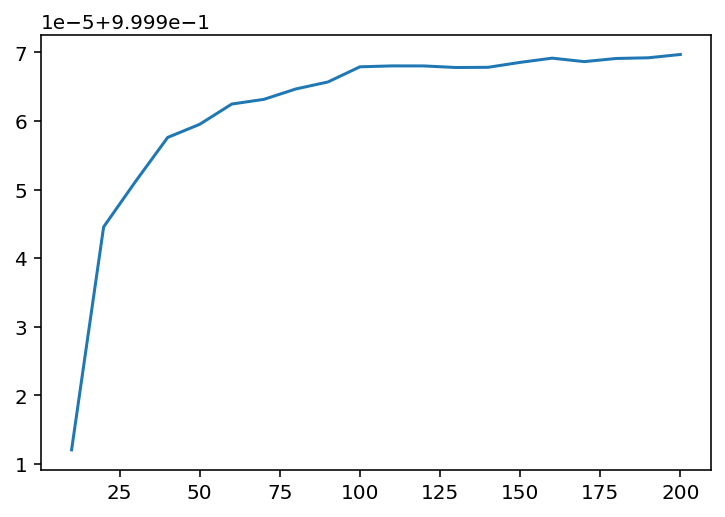

In [37]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

В&nbsp;целом результат ожидаемый&nbsp;— чем больше обученных моделей, тем лучше.

На&nbsp;тестовом наборе данных картина похожа:

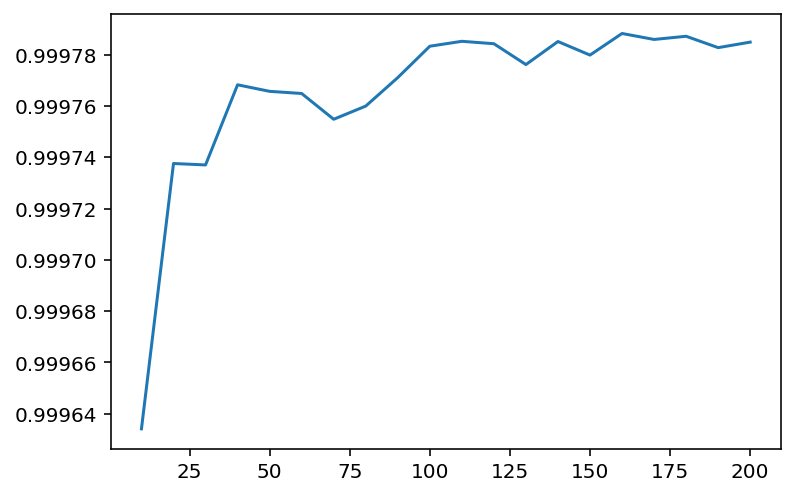

In [38]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Из-за присутствия элемента случайности, график немного скачет. Однако это не мешает найти лучший результат.

In [39]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 1.4076544943820246
median_absolute_error: 1.0437499999999886
r2_score: 0.999668509863967


Данная модель оказалась примерно такая же как и исходная.

### Градиентный бустинг

Список настраиваемых параметров оставим тем же.

In [40]:
tuned_parameters

[{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
         140, 150, 160, 170, 180, 190, 200])}]

Запустим подбор параметра:

In [41]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=70,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

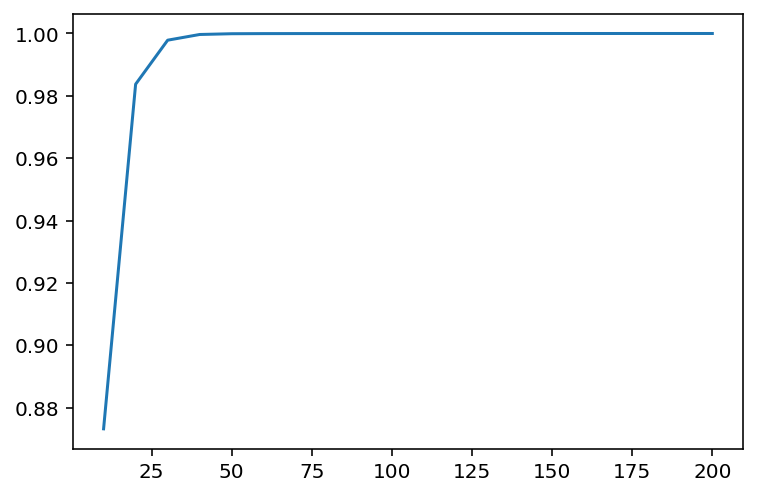

In [42]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Картина та же: чем больше подмоделей, тем лучше. Однако после определенного момента результат достигает пика и больше не меняется

На&nbsp;тестовом наборе данных картина ровно та же:

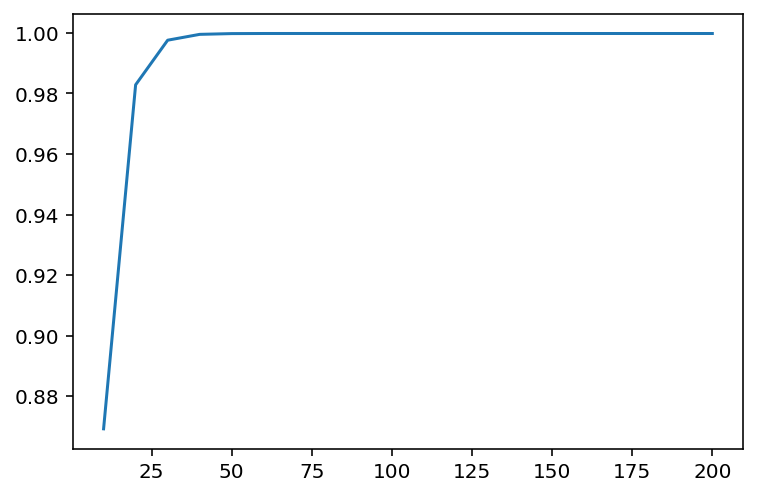

In [43]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Однако из полученных результатов можно выделить явную тенденцию: чем больше моделей тем лучше.

In [44]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 1.289725144853649
median_absolute_error: 1.1427072825601954
r2_score: 0.9997635451970246
